## Background

> 在今天的深度学习世界中，如果数据是王者，那么确保它的格式正确可能只是皇后，但这非常重要。在努力收集图像并注释所有对象之后，您必须确定将用于存储所有信息的格式。与您必须担心的所有其他事项相比，这似乎不是一个重大决定，但如果您想快速了解不同模型对您的数据的执行情况，那么让这一步骤正确至关重要。

> 早在2014年，Microsoft就创建了一个名为COCO（COntext中的公共对象）的数据集，以帮助推进对象识别和场景理解的研究。COCO是首批使用多个边界框注释对象的大型数据集之一，因此它成为测试新检测模型时使用的流行基准。COCO用于存储注释的格式从此成为事实上的标准，如果您可以将数据集转换为其样式，则会打开一整套最先进的模型实现。

> 这就是pycococreator的用武之地.pycococreator负责处理所有注释格式的详细信息，并将有助于将您的数据转换为COCO格式。

## Data structure

<code>
         
shapes
│
└───train
    │ 
    └───annotations
    │    │ <image_id>_<object_class_name>_<annotation_id>.png
    │    │ ...
    │   
    └───<subset><year>
         │   <image_id>.jpeg
         │   ...
    
</code>

## File content structure

### file name : instances_shapes_validate2018.json
<code language="json">
{
    "info": {
        "description": "Example Dataset",
        "url": "https://github.com/waspinator/pycococreator",
        "version": "0.1.0",
        "year": 2018,
        "contributor": "waspinator",
        "date_created": "2018-04-21 05:49:53.923111"
    },
    "licenses": [
        {
            "id": 1,
            "name": "Attribution-NonCommercial-ShareAlike License",
            "url": "http://creativecommons.org/licenses/by-nc-sa/2.0/"
        }
    ],
    "categories": [
        {
            "id": 1,
            "name": "square",
            "supercategory": "shape"
        },
        {
            "id": 2,
            "name": "circle",
            "supercategory": "shape"
        },
        {
            "id": 3,
            "name": "triangle",
            "supercategory": "shape"
        }
    ],
    "images": [
        {
            "id": 1,
            "file_name": "1038.jpeg",
            "width": 512,
            "height": 512,
            "date_captured": "2018-04-21 05:49:53.922945",
            "license": 1,
            "coco_url": "",
            "flickr_url": ""
        }
    ],
    "annotations": [
        {
            "id": 1,
            "image_id": 1,
            "category_id": 3,
            "iscrowd": 0,
            "area": 9139,
            "bbox": [
                0.0,
                64.0,
                133.0,
                127.0
            ],
            "segmentation": [
                [
                    132.0,
                    190.5,
                    0,
                    190.0,
                    0,
                    169.0,
                    60.0,
                    63.5,
                    132.0,
                    190.5
                ]
            ],
            "width": 512,
            "height": 512
        }
    ]
}
</code>

## <h>references and resources</h>

<p><a href="https://github.com/waspinator/pycococreator/">pycococreator</a></p>

<ul>
<li>COCO
<ul>
<li><a href="https://arxiv.org/abs/1405.0312">Original Microsoft COCO paper</a></li>
<li><a href="http://cocodataset.org">COCO dataset website</a></li>
<li><a href="https://github.com/cocodataset/cocoapi">COCO API</a></li>
</ul>
</li>
</ul>

<ul>
<li>Annotation tools
<ul>
<li><a href="https://github.com/CSAILVision/LabelMeAnnotationTool">Label Me</a></li>
<li><a href="https://github.com/kyamagu/js-segment-annotator">js-segment-annotator</a></li>
<li><a href="https://gitlab.com/vgg/via/">VGG Image Annotator</a></li>
<li><a href="https://github.com/AKSHAYUBHAT/ImageSegmentation">Image Eraser</a></li>
</ul>
</li>
</ul>

<ul>
<li>Deep learning implementations with COCO support
<ul>
<li><a href="https://github.com/waspinator/deep-learning-explorer/tree/master/mask-rcnn">Deep Learning Explorer&nbsp;</a></li>
<li><a href="https://github.com/facebookresearch/Detectron">Facebook Detectron</a></li>
<li><a href="https://github.com/tensorflow/models/tree/master/research/deeplab">Google DeepLab</a></li>
<li><a href="https://github.com/matterport/Mask_RCNN">Matterport Mask RCNN</a></li>
<li><a href="https://github.com/madhawav/YOLO3-4-Py">YOLO</a></li>
<li><a href="https://github.com/tryolabs/luminoth">Luminoth</a></li>
</ul>
</li>
</ul>

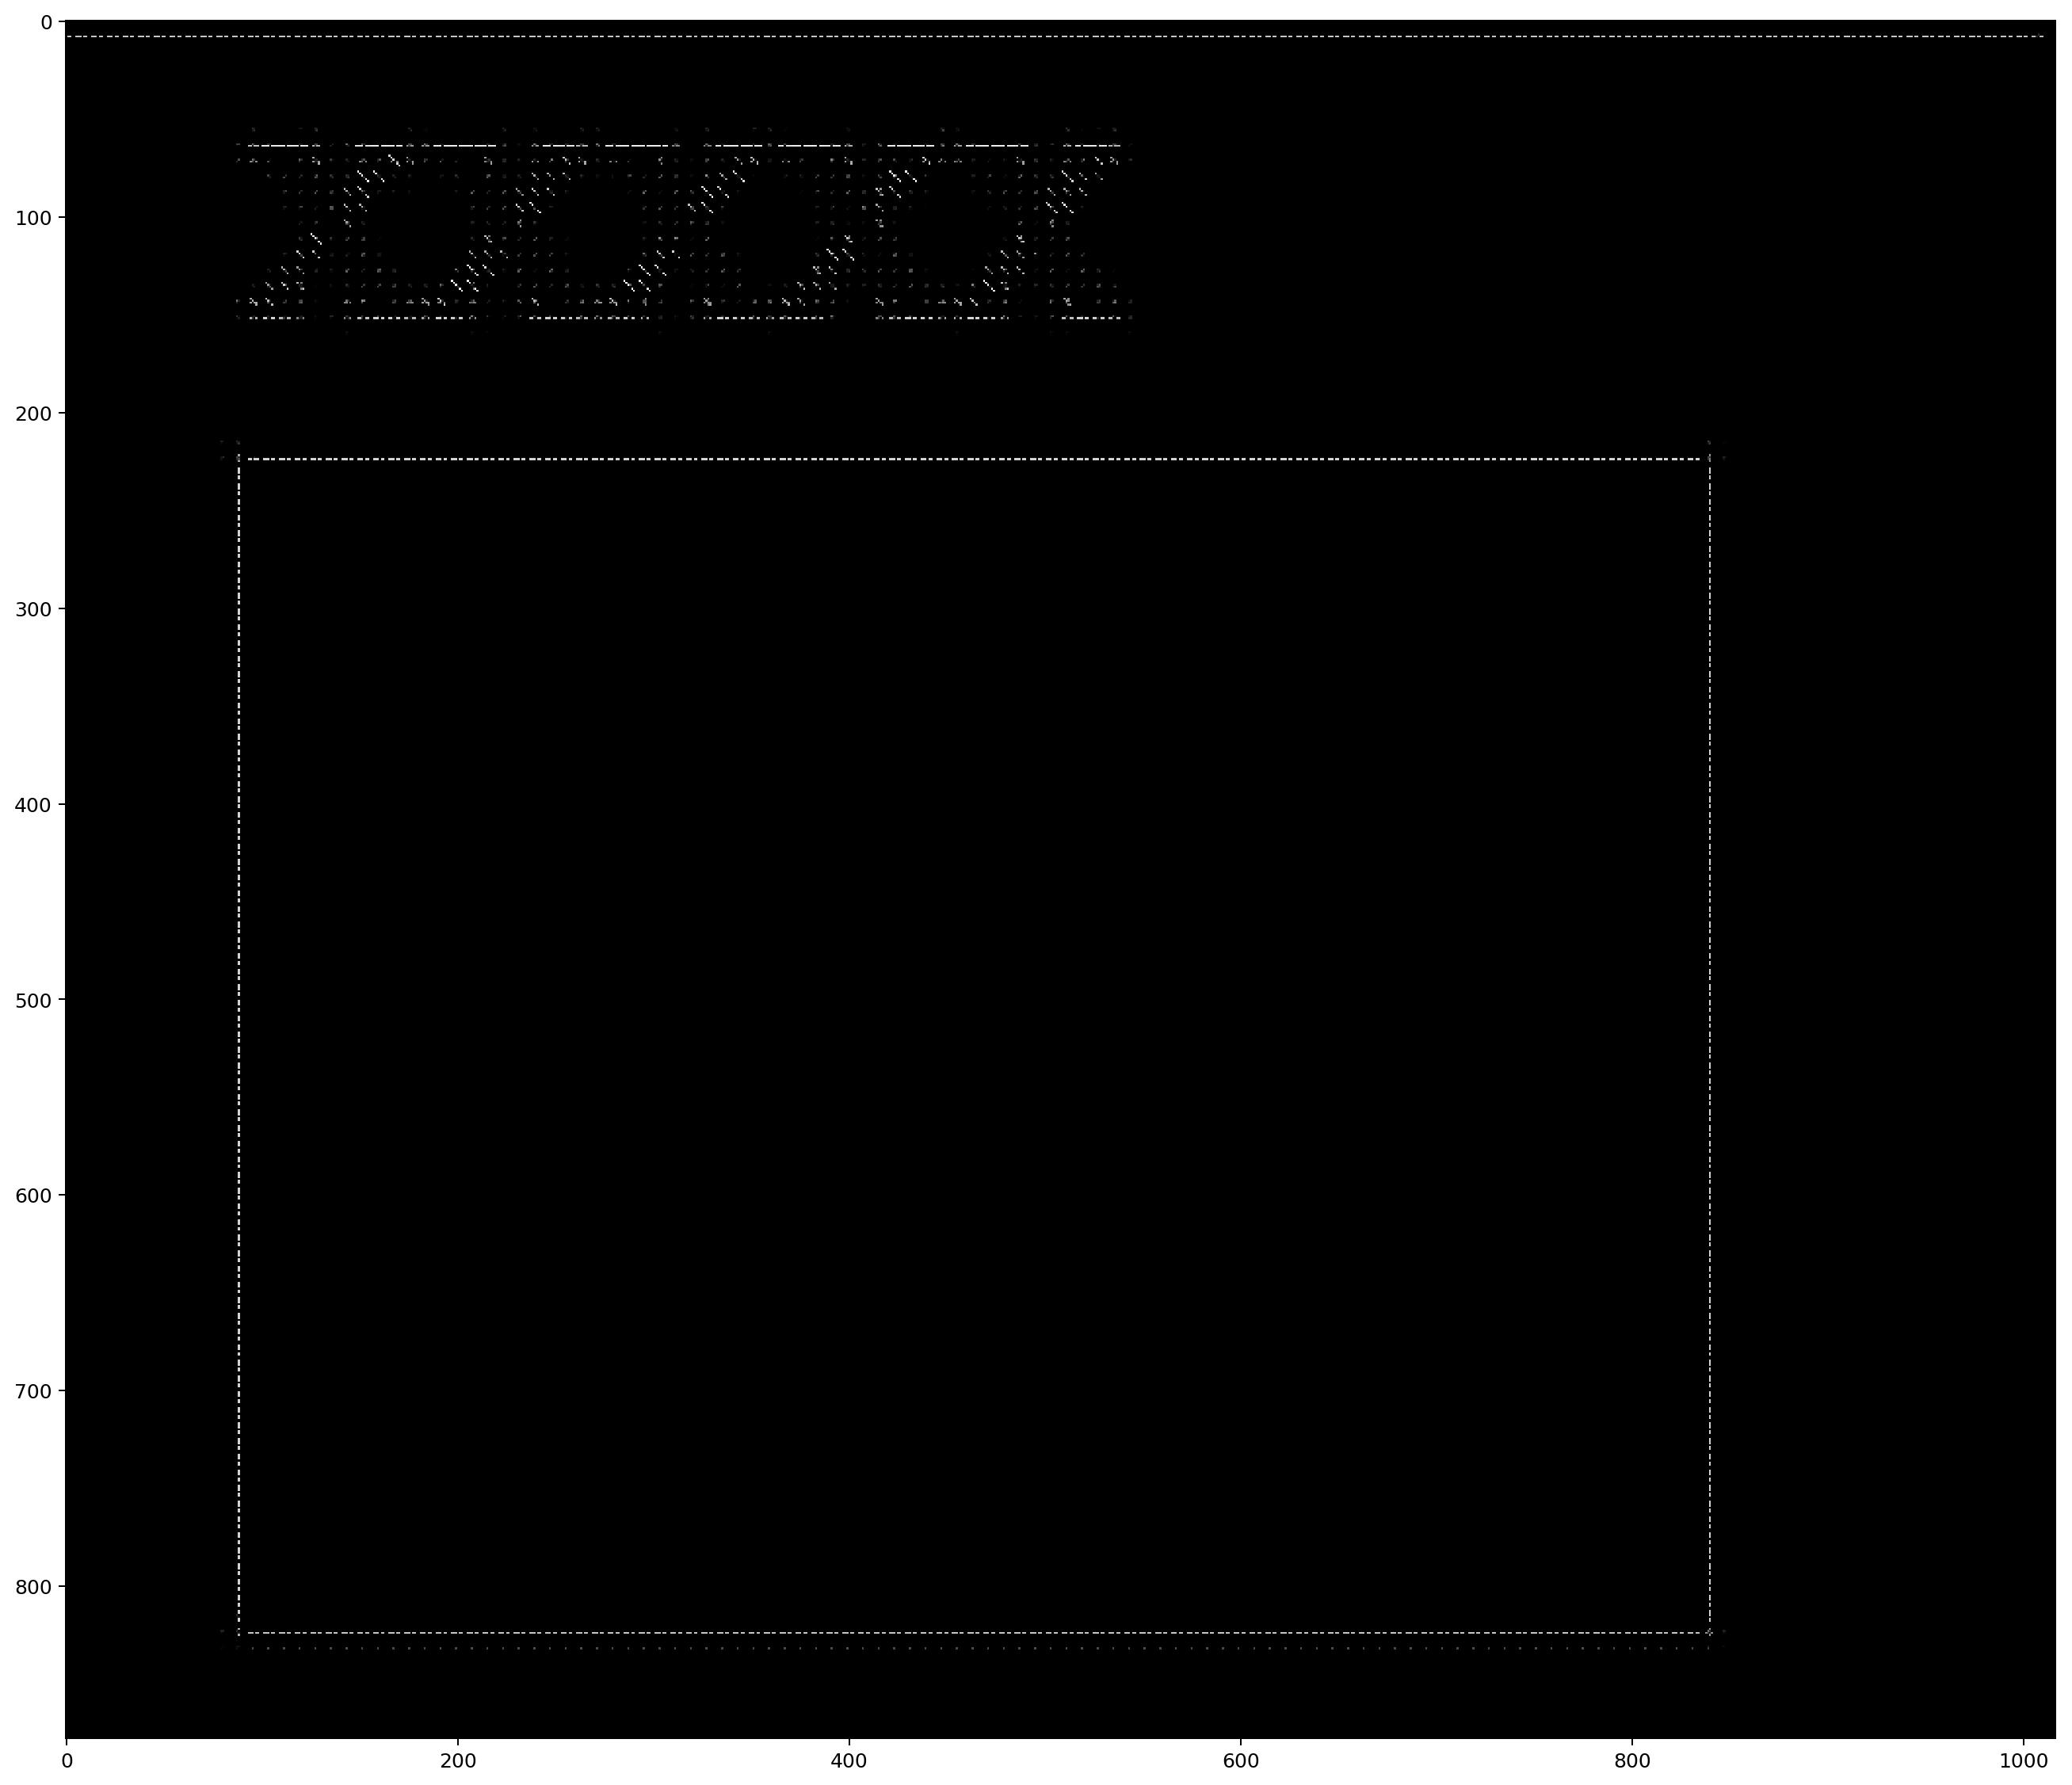

In [1]:
import cv2
import numpy as np
import math
import matplotlib.pyplot as plt

%matplotlib inline
fig=plt.figure(figsize=(18, 18), dpi= 180, facecolor='w', edgecolor='k')

class Hog_descriptor():
    def __init__(self, img, cell_size=16, bin_size=8):
        self.img = img
        self.img = np.sqrt(img // float(np.max(img)))
        self.img = self.img * 255
        self.cell_size = cell_size
        self.bin_size = bin_size
        self.angle_unit = 360 // self.bin_size
        assert type(self.bin_size) == int, "bin_size should be integer,"
        assert type(self.cell_size) == int, "cell_size should be integer,"
        #assert type(self.angle_unit) == int, "bin_size should be divisible by 360"

    def extract(self):
        height, width = self.img.shape
        gradient_magnitude, gradient_angle = self.global_gradient()
        gradient_magnitude = abs(gradient_magnitude)
        cell_gradient_vector = np.zeros((height // self.cell_size, width // self.cell_size, self.bin_size))
        for i in range(cell_gradient_vector.shape[0]):
            for j in range(cell_gradient_vector.shape[1]):
                cell_magnitude = gradient_magnitude[i * self.cell_size:(i + 1) * self.cell_size,
                                 j * self.cell_size:(j + 1) * self.cell_size]
                cell_angle = gradient_angle[i * self.cell_size:(i + 1) * self.cell_size,
                             j * self.cell_size:(j + 1) * self.cell_size]
                cell_gradient_vector[i][j] = self.cell_gradient(cell_magnitude, cell_angle)

        hog_image = self.render_gradient(np.zeros([height, width]), cell_gradient_vector)
        hog_vector = []
        for i in range(cell_gradient_vector.shape[0] - 1):
            for j in range(cell_gradient_vector.shape[1] - 1):
                block_vector = []
                block_vector.extend(cell_gradient_vector[i][j])
                block_vector.extend(cell_gradient_vector[i][j + 1])
                block_vector.extend(cell_gradient_vector[i + 1][j])
                block_vector.extend(cell_gradient_vector[i + 1][j + 1])
                mag = lambda vector: math.sqrt(sum(i ** 2 for i in vector))
                magnitude = mag(block_vector)
                if magnitude != 0:
                    normalize = lambda block_vector, magnitude: [element / magnitude for element in block_vector]
                    block_vector = normalize(block_vector, magnitude)
                hog_vector.append(block_vector)
        return hog_vector, hog_image

    def global_gradient(self):
        gradient_values_x = cv2.Sobel(self.img, cv2.CV_64F, 1, 0, ksize=5)
        gradient_values_y = cv2.Sobel(self.img, cv2.CV_64F, 0, 1, ksize=5)
        gradient_magnitude = cv2.addWeighted(gradient_values_x, 0.5, gradient_values_y, 0.5, 0)
        gradient_angle = cv2.phase(gradient_values_x, gradient_values_y, angleInDegrees=True)
        return gradient_magnitude, gradient_angle

    def cell_gradient(self, cell_magnitude, cell_angle):
        orientation_centers = [0] * self.bin_size
        for i in range(cell_magnitude.shape[0]):
            for j in range(cell_magnitude.shape[1]):
                gradient_strength = cell_magnitude[i][j]
                gradient_angle = cell_angle[i][j]
                min_angle, max_angle, mod = self.get_closest_bins(gradient_angle)
                orientation_centers[min_angle] += (gradient_strength * (1 - (mod / self.angle_unit)))
                orientation_centers[max_angle] += (gradient_strength * (mod / self.angle_unit))
        return orientation_centers

    def get_closest_bins(self, gradient_angle):
        idx = int(gradient_angle / self.angle_unit)
        mod = gradient_angle % self.angle_unit
        if idx == self.bin_size:
            return idx - 1, (idx) % self.bin_size, mod
        return idx, (idx + 1) % self.bin_size, mod

    def render_gradient(self, image, cell_gradient):
        cell_width = self.cell_size / 2
        max_mag = np.array(cell_gradient).max()
        for x in range(cell_gradient.shape[0]):
            for y in range(cell_gradient.shape[1]):
                cell_grad = cell_gradient[x][y]
                cell_grad /= max_mag
                angle = 0
                angle_gap = self.angle_unit
                for magnitude in cell_grad:
                    angle_radian = math.radians(angle)
                    x1 = int(x * self.cell_size + magnitude * cell_width * math.cos(angle_radian))
                    y1 = int(y * self.cell_size + magnitude * cell_width * math.sin(angle_radian))
                    x2 = int(x * self.cell_size - magnitude * cell_width * math.cos(angle_radian))
                    y2 = int(y * self.cell_size - magnitude * cell_width * math.sin(angle_radian))
                    cv2.line(image, (y1, x1), (y2, x2), int(255 * math.sqrt(magnitude)))
                    angle += angle_gap
        return image

img = cv2.imread('../test.png', cv2.IMREAD_GRAYSCALE)
hog = Hog_descriptor(img, cell_size=8, bin_size=8)
vector, image = hog.extract()
plt.imshow(image, cmap=plt.cm.gray)
plt.show()
